In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import  matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras
from keras import layers


2024-05-24 12:17:23.871649: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading Data

In [2]:
CSV_COLUMN_NAMES = ['sepalLength', 'sepalWidth', 'petalLength', 'petalWidth', 'species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']


In [3]:
VARIABLES = ['sepalLength', 'sepalWidth', 'petalLength', 'petalWidth']

In [4]:
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
val = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)


## Exploring Data

In [5]:
train.head()

,sepalLength,sepalWidth,petalLength,petalWidth,species
0,6.4,2.8,5.6,2.2,2
1,5.0,2.3,3.3,1.0,1
2,4.9,2.5,4.5,1.7,2
3,4.9,3.1,1.5,0.1,0
4,5.7,3.8,1.7,0.3,0


In [6]:
train.shape

(120, 5)

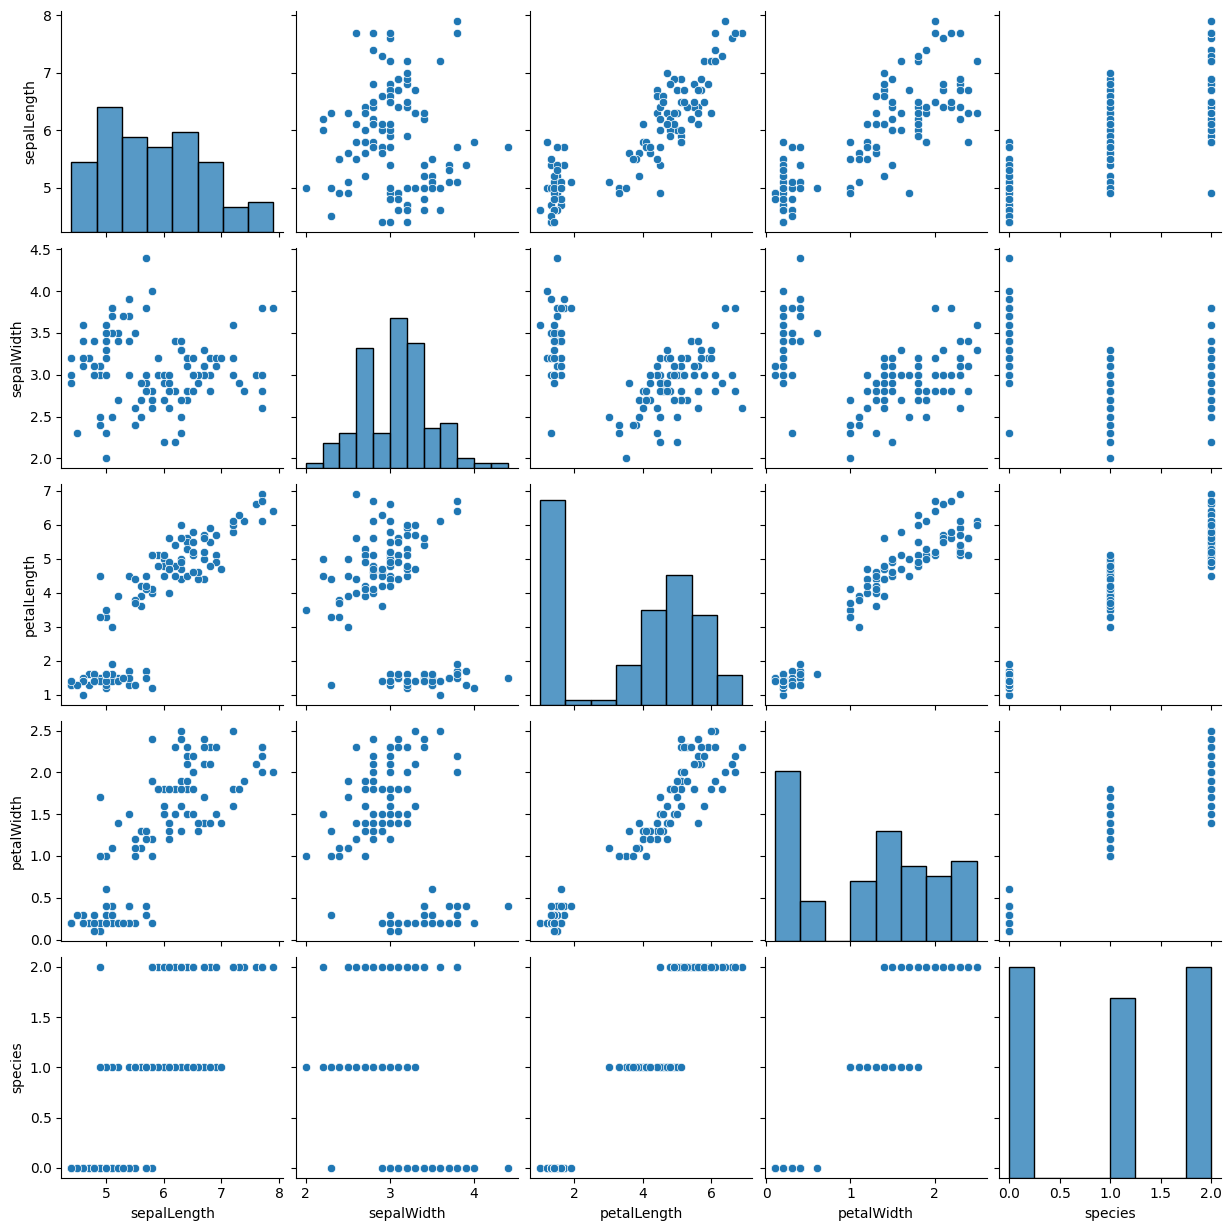

In [7]:
sns.pairplot(train)

<Axes: >

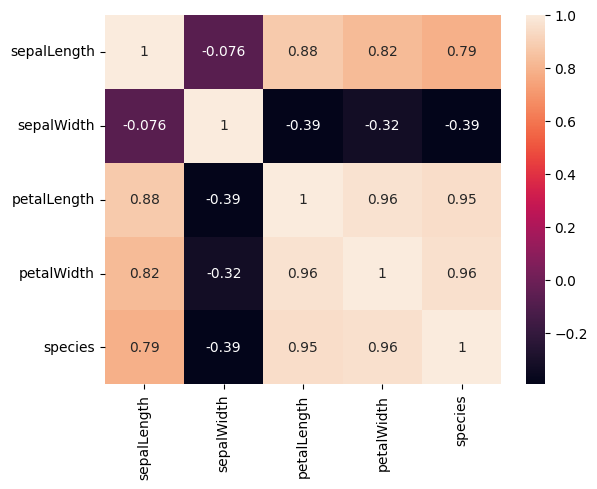

In [8]:
sns.heatmap(train.corr(), annot=True)

## Preparing the Data

In [9]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop('species')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

train_ds = dataframe_to_dataset(train)
val_ds = dataframe_to_dataset(val)

2024-05-24 12:17:27.734239: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:756] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-24 12:17:27.748964: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:756] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-24 12:17:27.749014: I tensorflow/compiler/xla/stream_executor/rocm/rocm_gpu_executor.cc:756] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-24 12:17:27.749028: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2266] Ignoring visible gpu device (device: 0, name: AMD Radeon RX 6650 XT, pci bus id: 0000:30:00.0) with AMDGPU version : gfx1032. The supported AMDGPU versions are gfx1030gfx1100, gfx900, gfx906, gfx908, gfx90a, gfx940, 

In [10]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)


Input: {'sepalLength': <tf.Tensor: shape=(), dtype=float64, numpy=5.0>, 'sepalWidth': <tf.Tensor: shape=(), dtype=float64, numpy=3.3>, 'petalLength': <tf.Tensor: shape=(), dtype=float64, numpy=1.4>, 'petalWidth': <tf.Tensor: shape=(), dtype=float64, numpy=0.2>}
Target: tf.Tensor(0, shape=(), dtype=int64)


2024-05-24 12:17:27.770974: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:27.771587: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:27.771953: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:27.774879: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


In [11]:
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)


2024-05-24 12:17:27.828179: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:27.828939: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


## Preprocessing

In [12]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = layers.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

## Creating the Model

In [13]:

sepalLength = keras.Input(shape=(1,), name='sepalLength')
sepalWidth = keras.Input(shape=(1,), name='sepalWidth')
petalLength = keras.Input(shape=(1,), name='petalLength')
petalWidth = keras.Input(shape=(1,), name='petalWidth')



all_inputs = [
    sepalLength,
    sepalWidth,
    petalLength,
    petalWidth
]

sepalLength_encoded = encode_numerical_feature(sepalLength, 'sepalLength', train_ds)
sepalWidth_encoded = encode_numerical_feature(sepalWidth, 'sepalWidth', train_ds)
petalLength_encoded = encode_numerical_feature(petalLength, 'petalLength', train_ds)
petalWidth_encoded = encode_numerical_feature(petalWidth, 'petalWidth', train_ds)

all_features = layers.concatenate(
    [
        sepalLength_encoded,
        sepalWidth_encoded,
        petalLength_encoded,
        petalWidth_encoded
    ]
)

x = layers.Dense(128, activation="relu")(all_features)
x = layers.Dense(64, activation="relu")(all_features)
x = layers.Dropout(0.3)(x)
output = layers.Dense(3, activation="softplus")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"], steps_per_execution='auto')

2024-05-24 12:17:27.853082: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:27.861461: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:27.862107: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:27.862512: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:27.863191: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:27.863621: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:27.864112: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:27.864787: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:27.865184: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:27

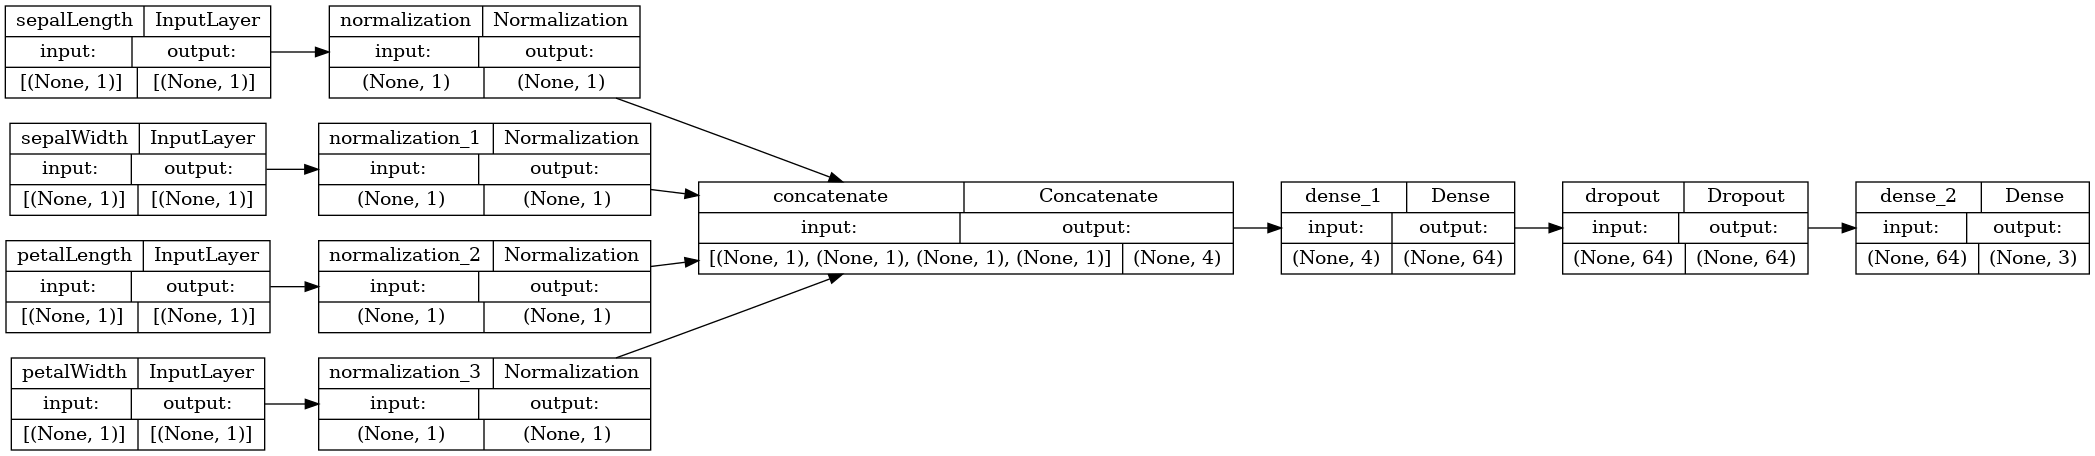

In [14]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

## Training the Model

In [15]:
model.fit(train_ds, epochs=100, validation_data=val_ds)


Epoch 1/100


2024-05-24 12:17:28.293784: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:28.294504: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


4/4 [==============================] - 0s 26ms/step - loss: 1.2000 - accuracy: 0.2750 - val_loss: 1.1258 - val_accuracy: 0.3333
Epoch 2/100
4/4 [==============================] - 0s 2ms/step - loss: 1.1497 - accuracy: 0.2917 - val_loss: 1.0919 - val_accuracy: 0.3000
Epoch 3/100
4/4 [==============================] - 0s 2ms/step - loss: 1.1021 - accuracy: 0.4083 - val_loss: 1.0593 - val_accuracy: 0.4667
Epoch 4/100
4/4 [==============================] - 0s 2ms/step - loss: 1.0614 - accuracy: 0.5083 - val_loss: 1.0278 - val_accuracy: 0.4667
Epoch 5/100
4/4 [==============================] - 0s 2ms/step - loss: 1.0391 - accuracy: 0.5667 - val_loss: 0.9974 - val_accuracy: 0.6000
Epoch 6/100
4/4 [==============================] - 0s 2ms/step - loss: 0.9833 - accuracy: 0.5750 - val_loss: 0.9678 - val_accuracy: 0.6333
Epoch 7/100
4/4 [==============================] - 0s 2ms/step - loss: 0.9411 - accuracy: 0.6167 - val_loss: 0.9392 - val_accuracy: 0.6667
Epoch 8/100
4/4 [=====================

2024-05-24 12:17:28.529486: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:28.536887: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:28.537335: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:28.537718: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:28.543342: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2024-05-24 12:17:28.609714: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


4/4 [==============================] - 0s 2ms/step - loss: 0.7141 - accuracy: 0.8167 - val_loss: 0.7746 - val_accuracy: 0.7333
Epoch 15/100
4/4 [==============================] - 0s 2ms/step - loss: 0.6810 - accuracy: 0.8250 - val_loss: 0.7559 - val_accuracy: 0.7000
Epoch 16/100
4/4 [==============================] - 0s 2ms/step - loss: 0.6698 - accuracy: 0.8333 - val_loss: 0.7381 - val_accuracy: 0.7000
Epoch 17/100
4/4 [==============================] - 0s 2ms/step - loss: 0.6467 - accuracy: 0.8083 - val_loss: 0.7217 - val_accuracy: 0.7000
Epoch 18/100
4/4 [==============================] - 0s 2ms/step - loss: 0.6370 - accuracy: 0.8167 - val_loss: 0.7064 - val_accuracy: 0.7000
Epoch 19/100
4/4 [==============================] - 0s 2ms/step - loss: 0.6129 - accuracy: 0.8000 - val_loss: 0.6922 - val_accuracy: 0.7000
Epoch 20/100
4/4 [==============================] - 0s 2ms/step - loss: 0.5756 - accuracy: 0.8083 - val_loss: 0.6790 - val_accuracy: 0.7000
Epoch 21/100
4/4 [===============

## Evaluate Model

In [22]:
hist = model.predict(val_ds)

1/1 [==============================] - 0s 3ms/step


In [23]:
hist.argmax(axis=1)

array([1, 0, 2, 0, 1, 0, 2, 1, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 0, 2, 2, 2,
       1, 0, 2, 1, 1, 1, 2, 1])

In [24]:
test = pd.DataFrame(columns=['val', 'pred'])
test['val'] = val.species
test['pred'] = hist.argmax(axis=1)
test['squares'] = (test['val'] - test['pred'])**2
rmse = np.sqrt(sum(test.squares)/len(test))

acc = test['squares'].value_counts()[0]/len(test)*100

print(f'Accuracy: {acc}%')
print(f'Root mean square error: {rmse}' )

Accuracy: 46.666666666666664%
Root mean square error: 1.0165300454651272
